<a href="https://colab.research.google.com/github/Summarizer-cb/Gas_Energy_Summarization/blob/main/%5B%EC%B0%BD%EC%9A%B0%5D1203_PretrainingStep.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 훈련시작


In [1]:
!pip install transformers
!pip install wandb
import torch
from torch.utils.data import DataLoader
from transformers import (AutoModel, AutoTokenizer, AdamW, BartForConditionalGeneration)
import re
import pandas as pd
from tqdm.auto import tqdm

     |████████████████████████████████| 3.1 MB 9.7 MB/s 
     |████████████████████████████████| 895 kB 70.1 MB/s 
     |████████████████████████████████| 596 kB 73.0 MB/s 
     |████████████████████████████████| 61 kB 492 kB/s 
     |████████████████████████████████| 3.3 MB 52.1 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
     |████████████████████████████████| 1.7 MB 8.6 MB/s 
     |████████████████████████████████| 140 kB 75.5 MB/s 
     |████████████████████████████████| 97 kB 9.0 MB/s 
     |████████████████████████████████| 180 kB 79.6 MB/s 
     |████████████████████████████████| 63 kB 2.4 MB/s 
  Created wheel for subprocess32: filename=subprocess32-3.5.4-py3-none-any.whl size=6502 sha256=81a48e61ae17806f437de96a15176a6fe09c5939e572844c93780befd276bdc0
  Stored in directory: /root/.cache/pip/wheels/50/ca/fa/8fca8d246e64f19488d07567547ddec8eb084e8c0d7a59226a
  Created w

## Dataloader

In [2]:
df = pd.read_csv("/content/drive/MyDrive/가스에너지문서요약/데이터셋/pretrain_dataset.csv")
df['Gap_sentence'] = df['Gap_sentence'].apply(eval)
df

,Unnamed: 0,index,content,Gap_sentence,con_len,gap_len
0,0,NaN,한국열관리시공협회(회장 유정범) 인천시회는 지난 4일 인천시 동구 괭이부리마을 내 ...,"[5, 4]",263,30
1,1,NaN,'발전용원자로 설치·운영자에 대한 행정처분(안)' 추후 재상정 결정 원자력안전위원회...,[3],149,68
2,2,NaN,관내 재난취약가구 13세대 새 보일러 교체 한국열관리시공협회(회장 유정범) 은평구회...,[3],173,43
3,3,NaN,업무협약 체결 승강기 안전사고 예방 및 안전문화 향상 지속 협업한국승강기안전공단은...,[3],251,73
4,4,NaN,두산중공업과 기술개발 상호협력 MOU 체결 탄소중립 선도(왼쪽 3번째) 송현규 한...,[2],248,45
...,...,...,...,...,...,...
509729,509729,NaN,"""10월 대구에는 정말 대단한 행사가 열립니다.<SEP>대구 시민들은 자부심을 가져...","[1, 8, 4, 0, 11]",337,92
509730,509730,NaN,이달 소비자물가가 1년전보다 4.2% 상승했습니다.<SEP>통계청이 발표한 소비자 ...,[5],129,60
509731,509731,NaN,"""신재생에너지 및 소재분야 연구개발(R&D)기관을 우정혁신도시 산.학.연 클러스터에...","[8, 6, 9]",359,156
509732,509732,NaN,"가스공 올해 22억 투입, 복지시설 난방 개선 등한국가스공사는 10월 30일 경기도...","[8, 1, 5]",334,77


In [3]:
df = df.sample(frac=1,random_state=42).reset_index(drop=True)
df

,Unnamed: 0,index,content,Gap_sentence,con_len,gap_len
0,306448,233635.0,인천이 화학물질 사고에 노출돼 있다.<SEP>시민들을 위협하는 화학물질 사고는 빈발...,"[15, 11, 6, 17, 8, 19]",362,133
1,247732,168601.0,지난달 초 100일이 지난 이헌욱 경기도시공사 사장(51·사진)은 새로운 임대주택 ...,"[12, 19, 15, 2, 11, 8]",504,130
2,449409,NaN,대구·경북 혁신 도시로 이전하는 도로공사와 가스공사 등 지방 이전 공공기관들의 이전...,"[3, 5]",231,37
3,220917,139074.0,이강덕(왼쪽) 포항시장과 올레그 구몌뉴크 블라디보스토크 시장이 기념촬영을 하고 있다...,"[6, 0]",362,87
4,397588,NaN,경남 마산시와 창원시가 추진해 오던 천연가스버스의 시범 운행 계획이 가스를 공급할 ...,"[4, 5]",216,89
...,...,...,...,...,...,...
509729,259178,181275.0,대한항공은 창립 50주년 기념 캠페인 대한 이야기 '모국방문 편'의 주인공인 로렌이...,"[6, 3]",199,88
509730,365838,NaN,북한 경수로 건설사업이 북핵위기 등 정치에 얽혀 진전을 보이지 못한 채 향후 추진방...,"[6, 5, 8]",467,76
509731,131932,40527.0,여승철 15일 '판타지 마당놀이' 학산소극장 공연 박 굴리고 노래 부르며 공동체의식...,"[10, 6, 7]",352,60
509732,146867,57110.0,과학기술정보통신부 우정사업본부는 오는 9월 2일 우체국 펀드판매 첫 돌을 기념하여 ...,"[9, 6, 5]",291,94


In [4]:
tokenizer = AutoTokenizer.from_pretrained("hyunwoongko/kobart")
added_token_num = tokenizer.add_special_tokens({"additional_special_tokens":["<GSG>"]})
tokenizer.special_tokens_map

Downloading:   0%|          | 0.00/109 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.08k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/436k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/172k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/666k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/85.0 [00:00<?, ?B/s]

{'additional_special_tokens': ['<GSG>'],
 'bos_token': '<s>',
 'cls_token': '<s>',
 'eos_token': '</s>',
 'mask_token': '<mask>',
 'pad_token': '<pad>',
 'sep_token': '</s>',
 'unk_token': '<unk>'}

In [5]:
class GapSentenceDatasets(torch.utils.data.Dataset):
  def __init__(self,df):
    self.tokenizer = tokenizer
    self.content = df['content']
    self.gap_sentence = df['Gap_sentence']
    assert type(self.gap_sentence[0]) == list
  
  def __getitem__(self,idx):
    temp = self.content[idx].split('<SEP>')
    docs = []
    gsg = []
    for i,doc in enumerate(temp):
      if i in self.gap_sentence[idx]:
        gsg.append(doc)
        docs.append('<GSG>')
      else :
        docs.append(doc)
    encoder_input_text = re.sub("\ *<GSG>\ *",'<GSG>',' '.join(docs))
    decoder_input_text = re.sub("\ *<s>\ *",'<s>',' '.join(["<s>"+s for s in gsg]))
    decoder_target_text = re.sub("\ *</s>\ *",'</s>',' '.join([s+"</s>" for s in gsg]))

    encoder_input_text = tokenizer.batch_encode_plus([encoder_input_text],padding='max_length', max_length=512, return_tensors="pt", truncation=True)
    decoder_input_text = tokenizer.batch_encode_plus([decoder_input_text],padding='max_length', max_length=512, return_tensors="pt")
    decoder_target_text = tokenizer.batch_encode_plus([decoder_target_text],padding='max_length', max_length=512, return_tensors="pt")

    return {"encoder_input_text": encoder_input_text, 
            "decoder_input_text": decoder_input_text, 
            "decoder_target_text": decoder_target_text}

  def __len__(self):
      return self.content.__len__()

  def __repr__(self):
    return f"data size : {self.__len__()} "


# 데이터 한번 다 읽는거 12분30초~13분30초 (토크나이징하는시간이 대부분)
datasets = GapSentenceDatasets(df)
# for i in tqdm(range(len(df))):
#   sample = datasets.__getitem__(i)

In [6]:
sample = datasets.__getitem__(0)
sample

{'decoder_input_text': {'input_ids': tensor([[    0, 23579, 11264, 29727, 19294, 19123, 11786, 15062, 15090, 19772,
          14884, 19697, 14730, 21158,     0, 15546,   252, 16224, 14460,   250,
          14205,   243, 27136, 16224, 26088, 14205, 14027, 23649, 14854, 14205,
          19171, 14027, 18668, 14528, 15964,     0, 15334, 15225, 19852, 11986,
          11803, 15334, 21303, 18815, 20418, 18082, 15196, 15526, 14382, 16454,
          14032, 14527, 15164, 10884, 14839, 14130,     0, 12037,  9233, 23897,
          16147, 13607, 16989, 14231, 14810, 19759, 10832, 15280, 18082, 21999,
          17380, 14807, 22209, 14528, 14857, 19553,     0, 29105, 11028, 14048,
          23220, 14777, 15415, 18282, 21632, 14783, 18825, 10795, 12790, 21369,
          18729, 28516, 20448, 11270, 15541, 17541, 14191, 15561, 24789, 15078,
          18814, 14262, 14166, 27859, 14394, 15324, 15461, 14575, 15416, 14041,
          12599, 22564,     0, 11802, 14424, 14880, 16660, 17677, 17085, 18693,
    

In [7]:
batch_size = 4
dataloader = DataLoader(datasets, shuffle=False, batch_size=batch_size) # batch 8개하니까 램 터짐

In [8]:
for sample in dataloader:
  for k,v in sample.items():
    print()
    print(k)
    for kk,vv in sample[k].items():
      print(kk, vv.shape) 
  break


encoder_input_text
input_ids torch.Size([4, 1, 512])
attention_mask torch.Size([4, 1, 512])

decoder_input_text
input_ids torch.Size([4, 1, 512])
attention_mask torch.Size([4, 1, 512])

decoder_target_text
input_ids torch.Size([4, 1, 512])
attention_mask torch.Size([4, 1, 512])


## Model

In [9]:
model = BartForConditionalGeneration.from_pretrained("hyunwoongko/kobart",return_dict=True)
model.resize_token_embeddings(tokenizer.vocab_size + added_token_num)

Downloading:   0%|          | 0.00/473M [00:00<?, ?B/s]

Embedding(30001, 768)

In [10]:
import glob
# bi = 0
# for f in glob.glob("/content/drive/MyDrive/가스에너지문서요약/Weights/*"):
#   if int(f.split('_')[-1].split('.')[0]) > bi:
#     pretrained_weight = f
#     bi = int(f.split('_')[-1].split('.')[0])
f = glob.glob("/content/drive/MyDrive/가스에너지문서요약/Weights/*")[-1]
pretrained_weight = f
bi = int(f.split('_')[-1].split('.')[0])
pretrained_weight

'/content/drive/MyDrive/가스에너지문서요약/Weights/KoPEGASUS_Pretraining_v1_4_96000.pt'

In [11]:
model.load_state_dict(torch.load(pretrained_weight))

<All keys matched successfully>

In [12]:
output = model.forward(input_ids=sample['encoder_input_text']['input_ids'].flatten(1), 
                        attention_mask=sample['encoder_input_text']['attention_mask'].flatten(1), 
                        decoder_input_ids=sample['decoder_input_text']['input_ids'].flatten(1), 
                        decoder_attention_mask=sample['decoder_input_text']['attention_mask'].flatten(1),
                        labels=sample['decoder_target_text']['input_ids'].flatten(1)
                       )

In [13]:
output.loss.backward()

In [14]:
print("loss :",output.loss)
print("logits :",output.logits.shape)
print("decoder_hidden_states :",output.decoder_hidden_states)
print("decoder_attentions :",output.decoder_attentions)
print("cross_attentions :",output.cross_attentions)
print("encoder_last_hidden_state :",output.encoder_last_hidden_state.shape)
print("encoder_hidden_states :",output.encoder_hidden_states)
print("encoder_attentions :",output.encoder_attentions)

loss : tensor(0.5746, grad_fn=<NllLossBackward0>)
logits : torch.Size([4, 512, 30001])
decoder_hidden_states : None
decoder_attentions : None
cross_attentions : None
encoder_last_hidden_state : torch.Size([4, 512, 768])
encoder_hidden_states : None
encoder_attentions : None


## Train

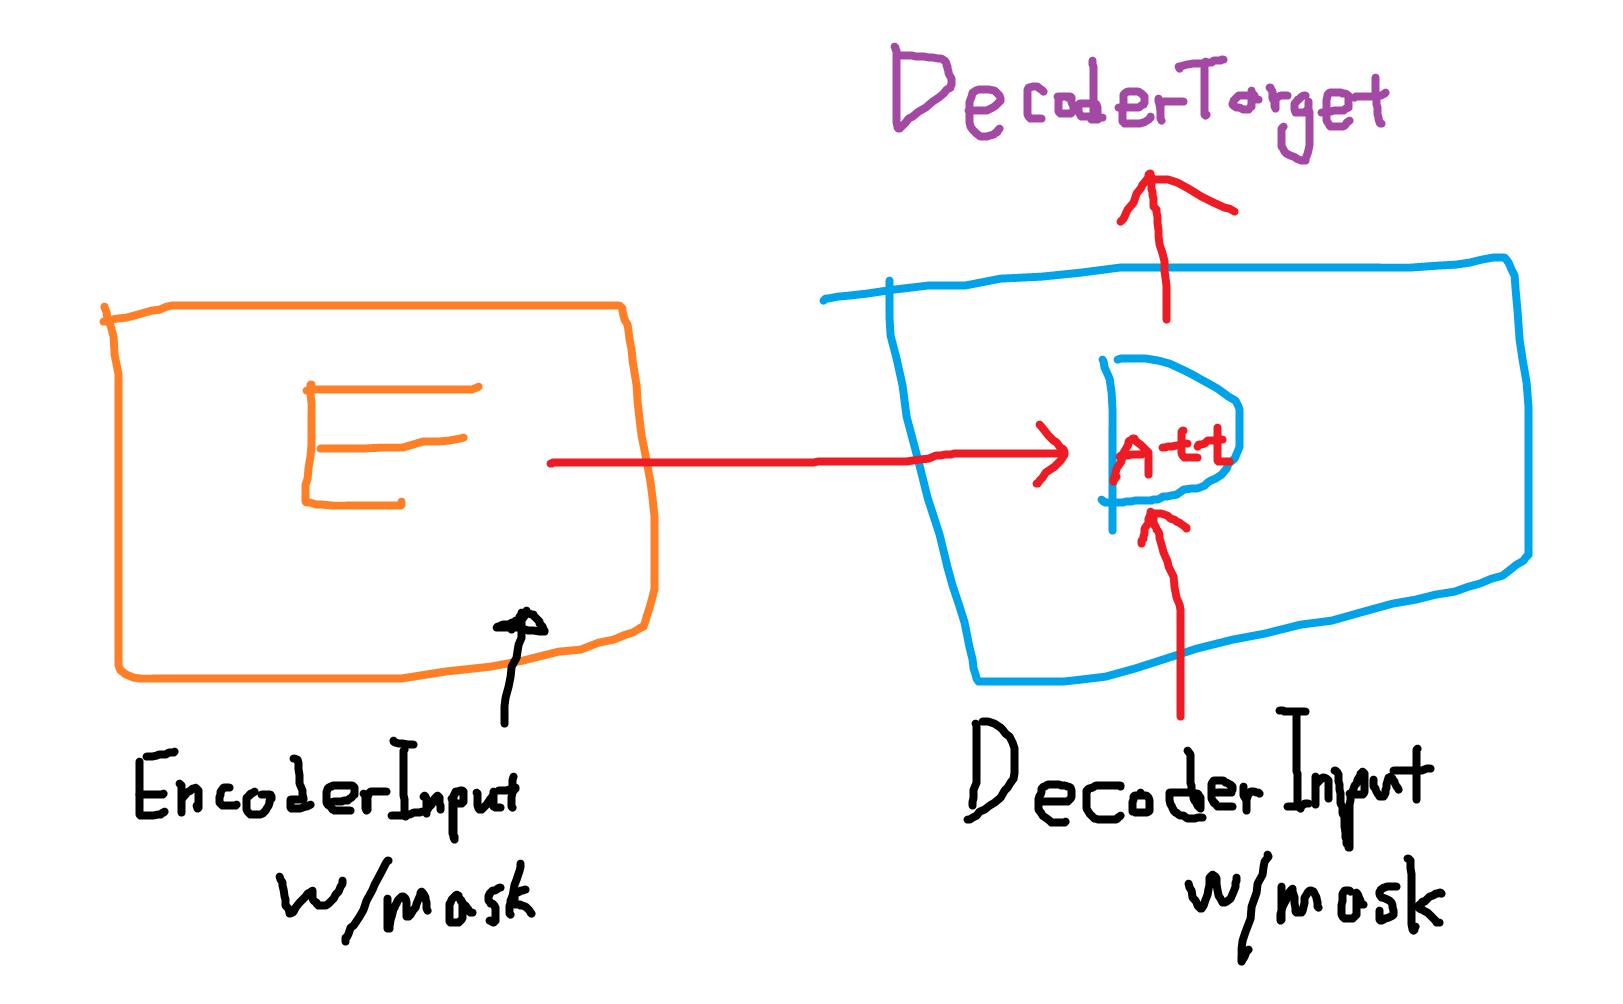

In [ ]:
!wandb login

In [ ]:
import wandb

wandb.login()

In [17]:
learning_rate = 2e-6
optimizer = AdamW(model.parameters(), lr=learning_rate)

num_epochs = 10
resume_epochs = int(pretrained_weight.split('_')[-2])
num_training_steps = (num_epochs - (resume_epochs-1)) * len(dataloader)

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model.to(device)
print("device :",device)
print("steps left :",num_training_steps)

device : cuda
steps left : 892038


In [19]:
config = dict(
    epochs=num_epochs,
    batch_size=batch_size,
    learning_rate=learning_rate)

In [20]:
# Validation 용
df_val = pd.read_csv("/<your_dir>/GSG_AIHUB_validate_10000.csv") 
df_val['Gap_sentence'] = df_val['Gap_sentence'].apply(eval)
df_val

,Unnamed: 0,index,title,content,abstractive,character_len,sentence_len,title_tok,content_tok,abstractive_tok,content_tok_len,Gap_sentence
0,0,361263,벼랑 끝 10 대 부모 학업·양육 병행 지원 시스템 필요해,서울신문 부모가 된 10 대에게 쏟아지는 세상의 시선은 싸늘하다.<SEP>그 싸늘한...,10대 부모들이 겪고 있는 현실적 악순환은 기성세대에 사회적 연대 책임 역시 있으므...,1004,15,"[10867, 10227, 14539, 14239, 14029, 15714, 290...","[[15295, 15955, 25596, 14464, 14239, 14029, 14...","[15684, 9776, 15714, 14108, 19733, 14082, 1515...",378,"[6, 5, 10, 3]"
1,1,361264,"이천도자기축제 ""관 주도행사 전락"" 불만 제기",김웅섭 지난 22일 이천 도예인들이 시청 앞 광장에서 도자기축제 행사에 돔 텐트를 ...,지난 22일 이천 도예인들이 시청 앞 광장에서 도자기축제 행사에 돔 텐트를 설치해 ...,1036,12,"[12034, 12673, 9866, 16109, 21372, 14050, 9123...","[[9275, 11926, 11277, 14141, 16670, 19989, 141...","[25560, 16670, 19989, 14121, 11828, 16707, 157...",418,"[2, 4, 10]"
2,2,361265,"영 ""노딜 브렉시트 땐 세관비용만 年19.3조원 증가""",또 향후 15년 간 경제 규모가 최대 9% 줄어들 것으로 예측됐다.<SEP>영국 정...,지난 26일 영국 정부가 발표한 노딜 브렉시트 시나리오를 따를 경우 경제에 끼치는 ...,927,18,"[11821, 14050, 9604, 10016, 14586, 10299, 1146...","[[10109, 16090, 27712, 14313, 14407, 19900, 14...","[25560, 16827, 15609, 15530, 17411, 14155, 100...",380,"[10, 17, 6, 9, 8]"
3,3,361266,성인 60% “유튜버 꿈꾼다”...월 기대수입 396만원,성인남녀 3543명 대상 설문뉴시스성인남녀 10명 중 6명이 ‘유튜버’를 하고 싶어...,구인구직 매칭플랫폼 사람인(대표 김용환)이 성인남녀 3543명을 대상으로 조사한 결...,1159,15,"[11280, 12037, 21930, 14128, 11986, 13319, 108...","[[11280, 12037, 9506, 9581, 17430, 251, 250, 1...","[9170, 12037, 9170, 12333, 14174, 12879, 13550...",509,"[14, 10, 11, 9]"
4,4,361267,"국민연금, 가입 모바일 통지 대상 늘린다",소득없는 배우자·경단여 등 이달부터 노후준비 서비스 제공 국민연금공단(이사장 김성주...,국민연금공단이 국민의 노후보장 강화를 위해 가입내역안내서 모바일 통지 대상자를 소득...,823,8,"[16121, 17548, 243, 15732, 15834, 14109, 12332...","[[16162, 16202, 15007, 12060, 373, 9085, 9758,...","[16121, 17548, 9115, 16334, 16455, 14155, 1678...",322,"[6, 1]"
...,...,...,...,...,...,...,...,...,...,...,...,...
9995,9995,371258,"아세안 5개국, 시청자 3명 중 2명 한방송 시청 경험",31일 방송통신위원회는 정보통신정책연구원과 함께 지난해 12월 아세안 5개국 현지 ...,31일 방송통신위원회는 지난해 12월 아세안 5개국 국가별로 각 500명씩을 무작위...,1166,17,"[11696, 11285, 11699, 18083, 25463, 15758, 120...","[[250, 15086, 24564, 18315, 23700, 15264, 1486...","[250, 15086, 24564, 18315, 14437, 15680, 14041...",446,"[11, 12, 13, 15, 16]"
9996,9996,371259,경주에너지과학연구단지 조성 속도가 중요,경북도·경주시·한국원자력연구원은 16 일 경주시 감포읍 나정리에 들어설 1 조원 규...,경북도·경주시·한국원자력연구원은 16 일 경주시 감포읍 나정리에 들어설 1조원 규모...,1236,17,"[9085, 18360, 15488, 15661, 14867, 17481, 1540...","[[20226, 9866, 373, 9085, 16518, 373, 15274, 2...","[20226, 9866, 373, 9085, 16518, 373, 15274, 29...",486,"[13, 8, 7, 2, 10]"
9997,9997,371260,부안군 종합감사 32건 적발,부안군에 대한 전북도의 종합감사 결과 결원을 초과한 승진 인사를 임용하는 등 총 3...,"27일 전북도는 최근 부안군 종합감사에서 시정 8건, 주의 7건, 시정주의 14건,...",892,9,"[10948, 11699, 9173, 15799, 21068, 18167, 9034...","[[10948, 11699, 20169, 14152, 17159, 15245, 15...","[20570, 12041, 17159, 15374, 14441, 14062, 116...",376,"[4, 6]"
9998,9998,371261,도내 바다양식장 1만2744ha 새만금사업 이전 규모 회복,전북도는 6일 도내 바다 양식장 면적이 새만금사업 이전으로 회복됐다고 밝혔다.<SE...,"전북도는 6일 도내 바다 양식장 7,683ha가 폐업 보상되면서 수산업이 크게 위축...",821,10,"[9866, 9517, 17017, 11747, 11466, 12074, 16248...","[[12126, 10949, 15374, 16601, 20457, 17017, 26...","[12126, 10949, 15374, 16601, 20457, 17017, 263...",366,"[2, 6, 4]"


In [21]:
val_datasets = GapSentenceDatasets(df_val)
val_dataloader = DataLoader(val_datasets, shuffle=False, batch_size=batch_size) # batch 8개하니까 램 터짐


In [ ]:
with wandb.init(project="<your_project>", config=config):
  progress_bar = tqdm(range(num_training_steps))
  model.train()
  wandb.watch(model, log="all", log_freq=10)
  for epoch in range(resume_epochs,num_epochs+1):
      total_loss = 0
      ### Train STEP
      for bindx, batch in enumerate(dataloader):
          if (epoch==resume_epochs) and (bindx<=bi):
            progress_bar.update(1)
            continue
          encoder_input_text, decoder_input_text, decoder_target_text = batch['encoder_input_text'],batch['decoder_input_text'],batch['decoder_target_text']
          encoder_input_text['input_ids'] = encoder_input_text['input_ids'].to(device)
          encoder_input_text['attention_mask'] = encoder_input_text['attention_mask'].to(device)
          decoder_input_text['input_ids'] = decoder_input_text['input_ids'].to(device)
          decoder_input_text['attention_mask'] = decoder_input_text['attention_mask'].to(device)
          decoder_target_text['input_ids'] = decoder_target_text['input_ids'].to(device)
          
          out = model.forward(input_ids=encoder_input_text['input_ids'].flatten(1), 
                              attention_mask=encoder_input_text['attention_mask'].flatten(1), 
                              decoder_input_ids=decoder_input_text['input_ids'].flatten(1), 
                              decoder_attention_mask=decoder_input_text['attention_mask'].flatten(1),
                              labels=decoder_target_text['input_ids'].flatten(1)
                              )

          loss = out.loss

          optimizer.zero_grad()
          out.loss.backward()
          optimizer.step()

          # Where the magic happens
          wandb.log({"epoch": epoch, "loss": loss, "batch":bindx, "total_loss":total_loss})

          with torch.no_grad():
              progress_bar.update(1)
              total_loss += loss.detach()

              if bindx%1500==0:
                  ### 1500마다 실제 아웃풋 출력, 모니터링, 가중치 저장
                  model.eval()
                  print(epoch, bindx,'-'*200)
                  for i in range(4):
                      monitor_input = ''.join(tokenizer.convert_ids_to_tokens(decoder_input_text['input_ids'][i][0])).replace('▁',' ').split("<pad>")[0][:130]
                      monitor_output = ''.join(tokenizer.convert_ids_to_tokens(torch.argmax(out.logits.to('cpu'),dim=-1).numpy()[i])).replace('▁',' ').split("<pad>")[0][:130]
                      print(monitor_input)
                      print(monitor_output)
                      print()
                  print('-'*204)

                  ### Val STEP 
                  val_loss = 0
                  for validx, batch in enumerate(val_dataloader):
                      
                      encoder_input_text, decoder_input_text, decoder_target_text = batch['encoder_input_text'],batch['decoder_input_text'],batch['decoder_target_text']
                      encoder_input_text['input_ids'] = encoder_input_text['input_ids'].to(device)
                      encoder_input_text['attention_mask'] = encoder_input_text['attention_mask'].to(device)
                      decoder_input_text['input_ids'] = decoder_input_text['input_ids'].to(device)
                      decoder_input_text['attention_mask'] = decoder_input_text['attention_mask'].to(device)
                      decoder_target_text['input_ids'] = decoder_target_text['input_ids'].to(device)
                      
                      out = model.forward(input_ids=encoder_input_text['input_ids'].flatten(1), 
                                          attention_mask=encoder_input_text['attention_mask'].flatten(1), 
                                          decoder_input_ids=decoder_input_text['input_ids'].flatten(1), 
                                          decoder_attention_mask=decoder_input_text['attention_mask'].flatten(1),
                                          labels=decoder_target_text['input_ids'].flatten(1)
                                          )

                      val_loss += out.loss
                  wandb.log({"val_loss": loss, "batch":bindx, "epoch": epoch})

                  torch.save(model.state_dict(), f"/<your_dir>/KoPEGASUS_Pretraining_v1_{epoch}_{bindx}.pt")
                  model.train()
              
      torch.save(model.state_dict(), f"/<your_dir>/KoPEGASUS_Pretraining_v1_{epoch}_done.pt")

  0%|          | 0/892038 [00:00<?, ?it/s]